### Step 2
# Process coordinate points and add altitude values

##### Import of Python libraries

In [1]:
import sys, mplstereonet
sys.path.append(r"..")  # append local path to access rgeomod module
import rgeomod
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Step 2b

# Load and transform coordinate data

<div class="alert alert-info">
**Your task**: Set the **folder_path** variable to the folder where your exported GoogleEarth data is located and execute the cell to load the point sets stored in the *.kml* files.
</div>

In [2]:
folder_path = "../data/FW2/"
point_sets, formation_names, ps_bool, fn = rgeomod.read_kml_files(folder_path)

read kml
1 point sets added
04_Unit4_fw2.kml


read kml
16 point sets added
01_Unit1_dips_fw2.kml


read kml
1 point sets added
02_Unit2_fw2.kml


read kml
1 point sets added
03_Unit3_fw2.kml


read kml
1 point sets added
01_Unit1_fw2.kml




*point_sets* contains the point set objects, containing the point data from the respective .kml files in the given directory:

In [3]:
point_sets

*formation_names* contains the formation names extracted from the filenames:

In [4]:
formation_names

['Unit4', 'Unit1', 'Unit2', 'Unit3', 'Unit1']

*ps_bool* is a boolean array specifying which object contains dip values:

In [5]:
ps_bool

array([False,  True, False, False, False], dtype=bool)

### Step 2c

# Add elevation values

<div class="alert alert-info">
**Your task**: Run the following cell to extract the elevation data for our point sets from the digital elevation model.
</div>

In [6]:
# set the path to the geotiff file:
geotiff_filepath = "../data/dome_sub_sub_utm.tif"

rgeomod.get_elevation_from_dtm(point_sets, geotiff_filepath)

Extracting elevation data: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

Elevation data successfully extracted from DTM.


### Step 2d

# Fit plane to points and determine orientations

<div class="alert alert-info">
Running the following cell will fit planes to the foliation point sets:
</div>

In [7]:
rgeomod.fit_planes_to_points(point_sets)

Fitting planes to point sets: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

Planes successfully fit to point sets.


### Step 2e

# Visualize data

### Convert data into readable DataFrames

<div class="alert alert-info">
Now we convert the interface and fitted foliation data stored in the point sets to a more intuitive data format: **Data Frames**, which simply represent data tables. 
</div>

In [8]:
interfaces, foliations = rgeomod.convert_to_df(point_sets, formation_names, fn, ps_bool)

In [9]:
foliations.tail()

,X,Y,Z,dip,azimuth,polarity,formation,series,formation number
11,617537.992479,2.479068e+06,461.875000,34.497184,349.883630,1,Unit4,Default series,1
12,619683.550025,2.478926e+06,469.375000,65.801180,43.522475,1,Unit4,Default series,1
13,620183.977449,2.478372e+06,467.900000,40.755717,53.592270,1,Unit4,Default series,1
14,617105.587985,2.475285e+06,602.000000,32.487338,148.738537,1,Unit4,Default series,1
15,618645.592616,2.476287e+06,575.714286,19.157720,117.215020,1,Unit4,Default series,1


<div class="alert alert-info">
Now that we have our data in a convenient format (Data Frames), we can use visualization techniques to better analyze our data. In the following we will make use of three different visualizations:
<br>

<ul>
    <li>Pseudo-3D visualization of the data points;</li>
    <li>Create histograms to visualize the distribution of dip angles and dip directions;</li>
    <li>Plot the orientation dip data in stereoplots.</li>
</ul>

</div>

#### 3D Point Cloud

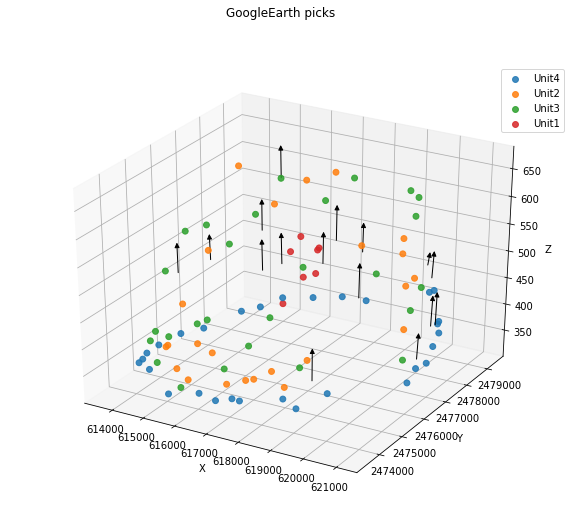

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for fmt in interfaces["formation"].unique():  # loop over all unique formations
    interf = interfaces[interfaces["formation"] == fmt]  # select only current formation
    ax.scatter(interf["X"], interf["Y"], interf["Z"], alpha=0.85, s=35, label=fmt)  # plot points of current formation

# plot foliation data
# ax.scatter(foliations["X"], foliations["Y"], foliations["Z"], color="black", alpha=0.85, s=35, label="Foliation data")
m = 75
rgeomod.calculate_gradient(foliations)

for i, row in foliations.iterrows():
    a = rgeomod.Arrow3D([row["X"], row["X"]+row["G_x"]*m],
                        [row["Y"], row["Y"]+row["G_y"]*m],
                        [row["Z"], row["Z"]+row["G_z"]*m],  mutation_scale=10,
                        lw=1, arrowstyle="-|>", color="k"
                       )
    ax.add_artist(a)

#ax.quiver(foliations["X"], foliations["Y"], foliations["Z"], 
#          foliations["G_x"], foliations["G_y"], foliations["G_z"], 
#          color="black", length=50, normalize=True, label="Foliation data")

ax.legend()  # plot legend
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
fig.suptitle("GoogleEarth picks");

#### Histograms

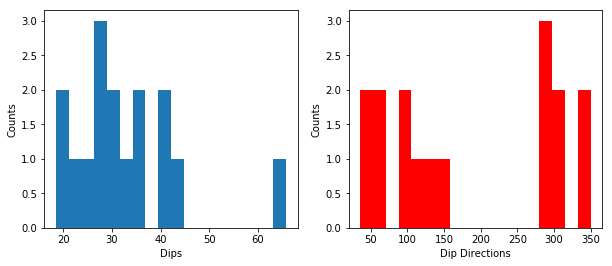

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(foliations["dip"], 18)
ax1.set_xlabel("Dips")
ax1.set_ylabel("Counts")

ax2.hist(foliations["azimuth"], 18, color='r');
ax2.set_xlabel("Dip Directions")
ax2.set_ylabel("Counts");

#### Stereonet plots

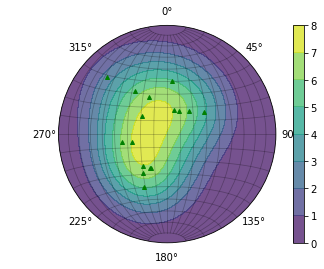

In [12]:
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(foliations["azimuth"], foliations["dip"], measurement='poles', cmap='viridis', alpha=0.75)
fig.colorbar(cax)
ax.pole(foliations["azimuth"], foliations["dip"], 'g^', markersize=4)
ax.grid(True, color="black", alpha=0.25)

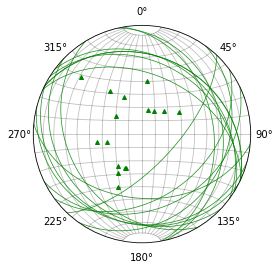

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.pole(foliations["azimuth"], foliations["dip"], 'g^', markersize=4)
ax.plane(foliations["azimuth"], foliations["dip"], 'g-', linewidth=0.75, alpha=0.85)
ax.grid(True, color="black", alpha=0.25)

# Save the data

<div class="alert alert-info">
Now that we successfully added height values, fit orientation data and got a more intuitive understanding our picked data through visualization, we can save it as *.csv* files for storage and later use for 3D geomodeling.
</div>

In [14]:
foliations.columns

Index(['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation', 'series',
       'formation number', 'G_x', 'G_y', 'G_z'],
      dtype='object')

In [15]:
interfaces.columns

Index(['X', 'Y', 'Z', 'formation', 'series', 'formation number'], dtype='object')

In [16]:
interfaces

,X,Y,Z,formation,series,formation number
0,613671.285221,2.474866e+06,345.0,Unit4,Default series,4
1,613644.465206,2.475391e+06,344.0,Unit4,Default series,4
2,613956.305870,2.475922e+06,354.0,Unit4,Default series,4
3,614275.816943,2.476477e+06,352.0,Unit4,Default series,4
4,614770.727404,2.477459e+06,362.0,Unit4,Default series,4
5,614966.550526,2.478031e+06,356.0,Unit4,Default series,4
6,615352.311329,2.478507e+06,365.0,Unit4,Default series,4
7,616023.191885,2.478962e+06,361.0,Unit4,Default series,4
8,616807.512726,2.479205e+06,366.0,Unit4,Default series,4
9,617480.818303,2.479356e+06,363.0,Unit4,Default series,4


In [17]:
interfaces.to_csv("../data/gempy_interfaces.csv", index=False)
foliations.to_csv("../data/gempy_foliations.csv", index=False)